# Integer programming: the assignment problem

In [10]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from itertools import product
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy

The functions below creates a networkx graph from an matrix with an assignment problem data 
and plot the graph. 

In [11]:
def graph_from_scores(scores):
    """
    Given an array with scores of the assignment problem 
    returns the corresponding weighted networkx graph. 
    Column nodes are labeled C1, C2, etc., row nodes P1, P2, etc.   

    scores:
        A 2-dimensional array with the assignment problem data.

    Returns: 
        A networkx weighted graph object.
    """

    df = pd.DataFrame(scores,
                      index=[f"P{i}" for i in range(1, scores.shape[0] + 1)],
                      columns=[f"C{i}" for i in range(1, scores.shape[1] + 1)])
    B = nx.Graph()  # Add nodes with the node attribute "bipartite"
    B.add_nodes_from([f"C{i}" for i in range(1, 8)], bipartite=0)
    B.add_nodes_from([f"P{i}" for i in range(1, 6)], bipartite=1)
    for p, c in product(df.index, df.columns):
        if (w := df.at[p, c]) > 0:
            B.add_edge(p, c, weight=w)
    return B


def plot_assignment_graph(B):
    """
    Plot the graph for an assignment problem. 

    B:
        A networkx object representing a weighted bipartite graph.
    
    Returns: 
        None. 
    """

    plt.figure(figsize=(10, 5))
    node_color = ['lightcoral' if n.startswith("C") else 'lightsteelblue' for n in B.nodes]
    nx.draw_networkx(
        B,
        pos = nx.drawing.layout.bipartite_layout(B, nodes = [n for n in B.nodes if n.startswith("C")]), 
        width = 3,
        node_color=node_color,
        node_size=1000
    )
    plt.show()


Create and plot the bipartite graph:

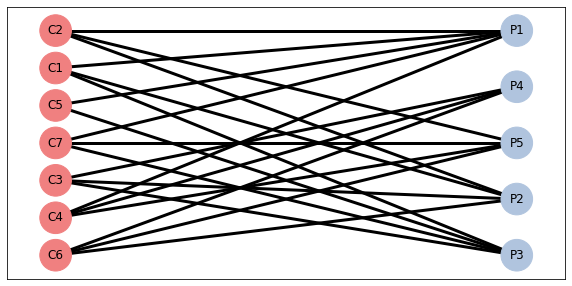

In [12]:
scores = np.array([[70, 90, 0, 75, 55, 0, 60],
                   [40, 95, 85, 0, 0, 80, 0],
                   [50, 0, 75, 0, 70, 0, 65],
                   [0, 0, 60, 80, 0, 35, 0],
                   [0, 75, 0, 70, 0, 35, 20]])

B = graph_from_scores(scores)
plot_assignment_graph(B)


### Solving the linear program for the assignment problem

The code below uses the networkx graph `B` produced below to print 
the weighted incidence matrix of the graph.

In [13]:
with np.printoptions(linewidth=100):
    print(nx.incidence_matrix(B, weight="weight").todense())

[[70. 40. 50.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. 90. 95. 75.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. 85. 75. 60.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 75. 80. 70.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 55. 70.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 80. 35. 35.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 60. 65. 20.]
 [70.  0.  0. 90.  0.  0.  0.  0.  0. 75.  0.  0. 55.  0.  0.  0.  0. 60.  0.  0.]
 [ 0. 40.  0.  0. 95.  0. 85.  0.  0.  0.  0.  0.  0.  0. 80.  0.  0.  0.  0.  0.]
 [ 0.  0. 50.  0.  0.  0.  0. 75.  0.  0.  0.  0.  0. 70.  0.  0.  0.  0. 65.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 60.  0. 80.  0.  0.  0.  0. 35.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. 75.  0.  0.  0.  0.  0. 70.  0.  0.  0.  0. 35.  0.  0. 20.]]


The next function solves an assignment problem, taking as its input the graph `B` produced above.

In [14]:
def lp_assignment(B):
    """
    Sets up and solves the assignment problem for
    a given weighted bipartite graph.
    
    B:
        A networkx object representing a weighted bipartite graph.
    
    Returns: 
       The data with the linear program solution returned by 
       scipy.optimize.linprog. 
    
    """
    weighted_incidence = nx.incidence_matrix(B, weight="weight").todense()
    edge_weights = weighted_incidence.max(axis=0)
    incidence = (weighted_incidence > 0).astype(int)
    num_slacks = len([n for n in B.nodes if n.startswith("C")])

    c = -edge_weights

    A_ub = incidence[:num_slacks]
    b_ub = np.ones(num_slacks)
    A_eq = incidence[num_slacks:]
    b_eq = np.ones(len(B.nodes) - num_slacks)

    sp = scipy.optimize.linprog(c=c,
                                A_ub=A_ub,
                                b_ub=b_ub,
                                A_eq=A_eq,
                                b_eq=b_eq)
    return sp

In [15]:
sol = lp_assignment(B)
sol

           con: array([0., 0., 0., 0., 0.])
 crossover_nit: 0
         eqlin:  marginals: array([-70., -80., -70., -65., -55.])
  residual: array([0., 0., 0., 0., 0.])
           fun: -380.0
       ineqlin:  marginals: array([ -0., -20.,  -5., -15.,  -0.,  -0.,  -0.])
  residual: array([0., 0., 0., 0., 1., 0., 1.])
         lower:  marginals: array([ 0., 40., 20.,  0.,  5.,  0.,  0.,  0., 10., 10.,  0.,  0., 15.,
        0.,  0., 30., 20., 10.,  5., 35.])
  residual: array([ 1.,  0.,  0., -0.,  0.,  1., -0.,  1.,  0.,  0.,  1., -0.,  0.,
        0.,  1.,  0.,  0.,  0.,  0.,  0.])
       message: 'Optimization terminated successfully. (HiGHS Status 7: Optimal)'
           nit: 9
         slack: array([0., 0., 0., 0., 1., 0., 1.])
        status: 0
       success: True
         upper:  marginals: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])
  residual: array([inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf

In [16]:
sol.x

array([ 1.,  0.,  0., -0.,  0.,  1., -0.,  1.,  0.,  0.,  1., -0.,  0.,
        0.,  1.,  0.,  0.,  0.,  0.,  0.])

To get a readable solution of the assignment problem, it is now enough to print information about the edges of the graph for which the linear program solution is equal to 1:

In [17]:
edges = list(B.edges(data=True))
assignment = [edges[i] for i in np.nonzero(sol.x)[0]]
assignment

[('C1', 'P1', {'weight': 70}),
 ('C2', 'P5', {'weight': 75}),
 ('C3', 'P3', {'weight': 75}),
 ('C4', 'P4', {'weight': 80}),
 ('C6', 'P2', {'weight': 80})]

The sum of weights of the optimal assignment:

In [254]:
sum([w["weight"] for c, p, w in assignment])

380